In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from subject_clf.dataset_imperial import dataset, subjects, short_term_weights_path
from subject_clf.subject_net import SubjectNet
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import itertools
from common.quaternion import *
from math import pi
from tqdm import tqdm
torch.cuda.set_device(1)


In [2]:
from long_term.dataset_imperial import dataset, long_term_weights_path
from long_term.locomotion_utils import build_extra_features, compute_splines
from long_term.pose_network_long_term import  PoseNetworkLongTerm
from common.spline import Spline
from common.visualization_patrick import render_animation, render_animation_dual

if torch.cuda.is_available():
    dataset.cuda()
dataset.compute_euler_angles('yzx')
dataset.compute_positions()
build_extra_features(dataset)

from long_term.pace_network import PaceNetwork

traj = np.array([[-i*0.1,0] for i in range(1737)])
pace_net = PaceNetwork()
pace_net.load_weights('weights_pace_network.bin')
spline = Spline(traj, closed=False)

Loading weights from weights_pace_network.bin


# parameters: 9545250
Loading weights from weights_long_term.bin


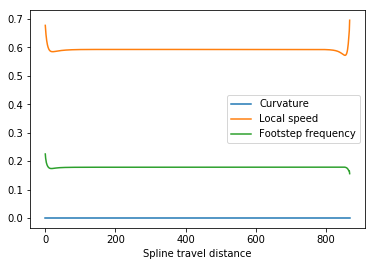

In [8]:
# We want the character to walk
%matplotlib inline
spline_walk = pace_net.predict(spline, average_speed=0.5)
plt.plot(spline_walk.get_track('curvature'))
plt.plot(spline_walk.get_track('amplitude'))
plt.plot(spline_walk.get_track('frequency'))
plt.legend(['Curvature', 'Local speed', 'Footstep frequency'])
_ = plt.xlabel('Spline travel distance')

model = PoseNetworkLongTerm(32, dataset.skeleton())
if torch.cuda.is_available():
    model.cuda()
model.load_weights('weights_long_term.bin') # Load pretrained model

1684 frames generated in 1.777 seconds (947.54 FPS)


<IPython.core.display.Javascript object>


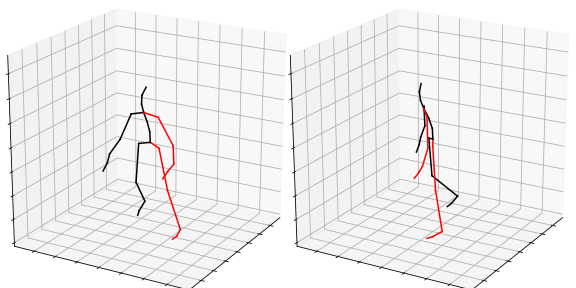

In [5]:
traj = np.array([[i,0] for i in range(1000)])
spline = Spline(traj, closed=False)
spline_walk = pace_net.predict(spline, average_speed=0.5)

spline_walk.tracks['direction'][0][:,0] = 1
spline_walk.tracks['direction'][0][:,1] = 1

%matplotlib notebook
prediction, rotations = model.generate_motion(spline_walk, dataset['Subject4']['walking_2_d1'])
anim = render_animation_dual(dataset['Subject4']['walking_2_d1']['positions_world'][model.prefix_length:],
                             prediction, dataset.skeleton(), dataset.fps(), output='interactive',lines_plot=False)

Traceback (most recent call last):
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/zhome/65/2/97979/Deep_learning/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


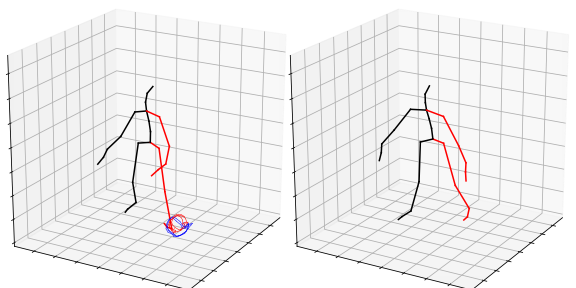

In [6]:
%matplotlib notebook

zoom_right_arm = [-0/10,2/10,-3/10,-1/10,3/10,5/10]
zoom_left_foot = [-0.8/10,1.2/10,1/10,3/10,0/10,2/10]

prediction_test = prediction.copy()
for i in range(prediction_test.shape[0]):
    v = np.array(prediction_test[i,:,:])
    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
    q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
    prediction_test[i] = qrot_np(q,v)
anim = render_animation_dual(dataset['Subject4']['walking_2_d1']['positions_world'][model.prefix_length:][:],
                             prediction_test[:], dataset.skeleton(), dataset.fps(), output='interactive')

1684 frames generated in 1.765 seconds (953.85 FPS)


<IPython.core.display.Javascript object>


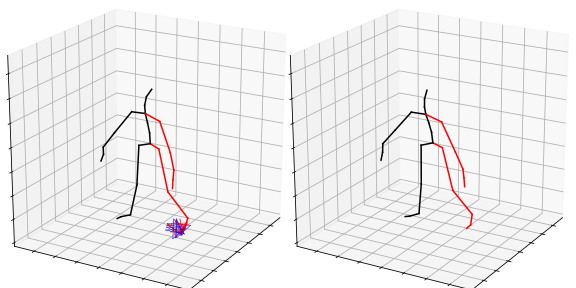

In [10]:
%matplotlib notebook

dat = dataset['Subject4']['walking_2_d1']
prediction, rotations = model.generate_motion(spline_walk, dat)

zoom_right_arm = [-0/10,2/10,-3/10,-1/10,3/10,5/10]
zoom_left_foot = [-0.8/10,1.2/10,1/10,3/10,0/10,2/10]

prediction_test = prediction.copy()
for i in range(prediction_test.shape[0]):
    v = np.array(prediction_test[i,:,:])
    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
    q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
    prediction_test[i] = qrot_np(q,v)
anim = render_animation_dual(dat['positions_world'][model.prefix_length:][10:200:10],
                             prediction_test[10:200:10], dataset.skeleton(), dataset.fps(), output='interactive')

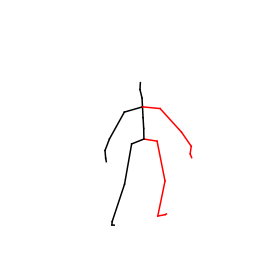

In [7]:
prediction_test = prediction.copy()
#for i in range(prediction_test.shape[0]):
#    v = np.array(prediction_test[i,:,:])
#    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
#    q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
#    prediction_test[i] = qrot_np(q,v)
anim = render_animation(prediction_test[10:200:10], dataset.skeleton(), dataset.fps(), output='interactive',grid=False)

292 frames generated in 0.395 seconds (738.92 FPS)


<IPython.core.display.Javascript object>


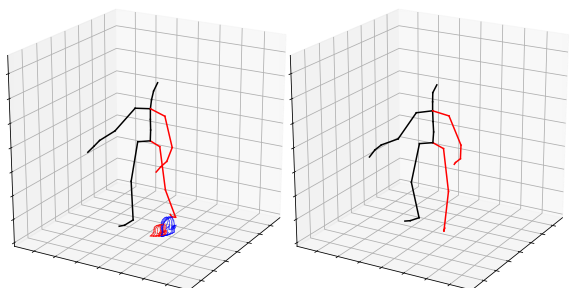

In [43]:
%matplotlib notebook
sub = "Subject2"
save_pred = sub+"pred"+".gif"
save_true = sub+"true"+".gif"
dat = dataset[sub]['walking_2_d1']
prediction, rotations = model.generate_motion(spline_walk, dat)
prediction_test = prediction.copy()
for i in range(prediction_test.shape[0]):
    v = np.array(prediction_test[i,:,:])
    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
    q = np.tile(euler_to_quaternion(np.array([[0,+pi/3,0]]),'zyx'),(27,1))
    prediction_test[i] = qrot_np(q,v)
tran = 10
anim = render_animation_dual(dat['positions_world'][model.prefix_length:][10+tran:200+tran],
                             prediction_test[10:200], dataset.skeleton(), dataset.fps(), output='interactive',lines_plot=True)

In [44]:
anim = render_animation(prediction_test[10:200:10], dataset.skeleton(), dataset.fps(), output=save_pred,grid=False)

In [45]:
anim = render_animation(dat['positions_world'][model.prefix_length:][10+tran:200+tran:10], dataset.skeleton(), dataset.fps(), output=save_true,grid=False)

In [8]:
len(prediction_test[10:200])

190

In [12]:
from importlib import reload
import common.visualization_patrick as cv
cv = reload(cv)

<IPython.core.display.Javascript object>


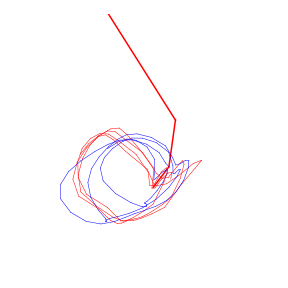

In [14]:
%matplotlib notebook

zoom_right_arm = [-0/10,2/10,-3/10,-1/10,3/10,5/10]
zoom_left_foot = [-0.8/10,1.2/10,1/10,3/10,0/10,2/10]

prediction_test = prediction.copy()
for i in range(prediction_test.shape[0]):
    v = np.array(prediction_test[i,:,:])
    #q = np.array([[0,0,1,0] for _ in range(v.shape[0])])
    q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
    prediction_test[i] = qrot_np(q,v)
anim = cv.render_animation(prediction_test[10:100], dataset.skeleton(), dataset.fps(),zoom = zoom_left_foot, output='interactive',grid=False,joints = [9,21],data2=dataset['Subject4']['walking_2_d1']['positions_world'][model.prefix_length:][20:110])


In [12]:
plt.show()

Text(0,0.5,'Joints')

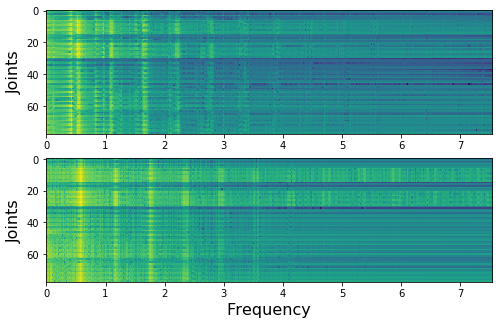

In [65]:
npt = 800
chunk_gen = prediction_test.reshape(-1,27*3)[:npt]
chunk_dat = dataset['Subject4']['walking_2_d0']['positions_world'][model.prefix_length+10:model.prefix_length+npt+10].reshape(-1,27*3)
fft_gen = np.fft.rfft(chunk_gen, axis=0)
fft_dat = np.fft.rfft(chunk_dat, axis=0)
freqs = np.fft.rfftfreq(npt, 1/dataset.fps())

%matplotlib inline
plt.figure(figsize=(8,5))
#plt.plot(freqs[1:], np.mean(np.abs(fft_dat[1:,::3]),axis=1))
#plt.plot(freqs[1:], np.mean(np.abs(fft_gen[1:,::3]),axis=1))
#plt.plot(np.real(fft_dat[1:,4]), np.imag(fft_dat[1:,12]),'.')
#plt.plot(np.real(fft_gen[1:,4]), np.imag(fft_gen[1:,5]),'.')


ax1 = plt.subplot(211)
plt.imshow(np.log(np.abs(fft_gen[1:,3:].T)), aspect='auto')
ax1.set_xticks(range(0,400,53))
ax1.set_xticklabels(range(10))
ax1.set_ylabel("Joints", fontsize = 16)

ax2 = plt.subplot(212)
plt.imshow(np.log(np.abs(fft_dat[1:,3:].T)), aspect='auto')
ax2.set_xticks(range(0,400,53))
ax2.set_xticklabels(range(10))
ax2.set_xlabel("Frequency", fontsize = 16)
ax2.set_ylabel("Joints", fontsize = 16)

#plt.subplot(313)
#plt.imshow(np.log(np.abs(np.abs(fft_dat[1:,3::3].T) - np.abs(fft_gen[1:,3::3].T))), aspect='auto')
#plt.colorbar()

In [55]:
fft_dat.shape

(401, 81)

In [64]:
plt.figure()
fft_dat

400

In [63]:
np.log(np.abs(fft_dat[1:,3::3].T)).shape

(26, 400)

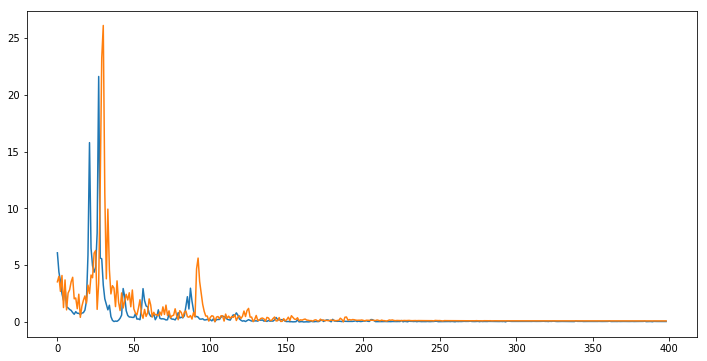

In [111]:
plt.figure(figsize=(12,6))
plt.plot(np.abs(fft_gen[2:,8]))
plt.plot(np.abs(fft_dat[2:,8]))

In [14]:
def logspecdist(spec1, spec2):
    return np.sum(np.sqrt(np.sum(100*(np.log10(np.abs(spec1)/np.abs(spec2))**2), axis=0)))

In [51]:
nsubject = len(dataset.subjects())
npt = 800
D = np.zeros((2*nsubject,2*nsubject))

pred = [[] for _ in range(nsubject)]
chunk_gen = [[] for _ in range(nsubject)]
chunk_dat = [[] for _ in range(nsubject)]
fft_gen   = [[] for _ in range(nsubject)]
fft_dat   = [[] for _ in range(nsubject)]

for i, s1 in enumerate(tqdm(dataset.subjects())):
    
    pred[i] = model.generate_motion(spline_walk, dataset[s1]['walking_2_d0'], do_print=False)[0]
    for j in range(pred[i].shape[0]):
        v = np.array(pred[i][j,:,:])
        q = np.tile(euler_to_quaternion(np.array([[0,-pi/6.5,0]]),'zyx'),(27,1))
        pred[i][j] = qrot_np(q,v)
    
    chunk_gen[i] = pred[i].reshape(-1,27*3)[:npt]
    chunk_dat[i] = dataset[s1]['walking_2_d0']['positions_world'][model.prefix_length:model.prefix_length+npt].reshape(-1,27*3)
    fft_gen[i] = np.fft.rfft(chunk_gen[i][:,3:], axis=0)
    fft_dat[i] = np.fft.rfft(chunk_dat[i][:,3:], axis=0)

for i, s1 in enumerate(tqdm(dataset.subjects())):
    for j, s2 in enumerate(dataset.subjects()):
        D[i,j] = logspecdist(fft_dat[i], fft_dat[j])
        D[i,j+nsubject] = logspecdist(fft_dat[i], fft_gen[j])
        D[i+nsubject,j] = logspecdist(fft_gen[i], fft_dat[j])
        D[i+nsubject,j+nsubject] = logspecdist(fft_gen[i], fft_gen[j])


100%|██████████| 25/25 [04:05<00:00,  6.24s/it]

100%|██████████| 25/25 [00:05<00:00,  4.68it/s]


Text(0,0.5,'Subject')

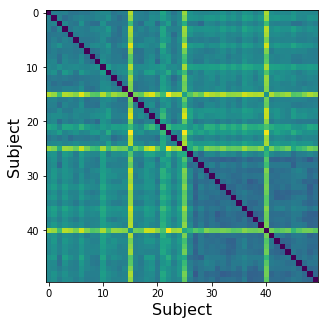

In [68]:
Dp = D
#to_remove = np.array([15])
#Dp = np.delete(Dp, nsubject+to_remove, 1)
#Dp = np.delete(Dp, to_remove, 1)
#Dp = np.delete(Dp, nsubject+to_remove, 0)
#Dp = np.delete(Dp, to_remove, 0)

%matplotlib inline
plt.figure(figsize=(5,5))
plt.imshow(Dp)
plt.xlabel("Subject",fontsize=16)
plt.ylabel("Subject",fontsize=16)